[*********************100%***********************]  5 of 5 completed
[*******************   40%                       ]  2 of 5 completed


=== Optimized Portfolio Weights ===
GLDM_KRW: 72.00%
QQQM_KRW: 1.35%
WM_KRW: 15.86%
BTC_KRW: 10.78%

=== Recommended Orders ===
GLDM_KRW: 82 shares
QQQM_KRW: 0 shares
WM_KRW: 4 shares
BTC_KRW: 1,034,912 KRW


[*********************100%***********************]  5 of 5 completed



Portfolio Backtesting Results
Final Portfolio Value: 1,010,379 KRW
Annualized Return: 16.26%
Annualized Volatility: 19.53%
Sortino Ratio: 0.94


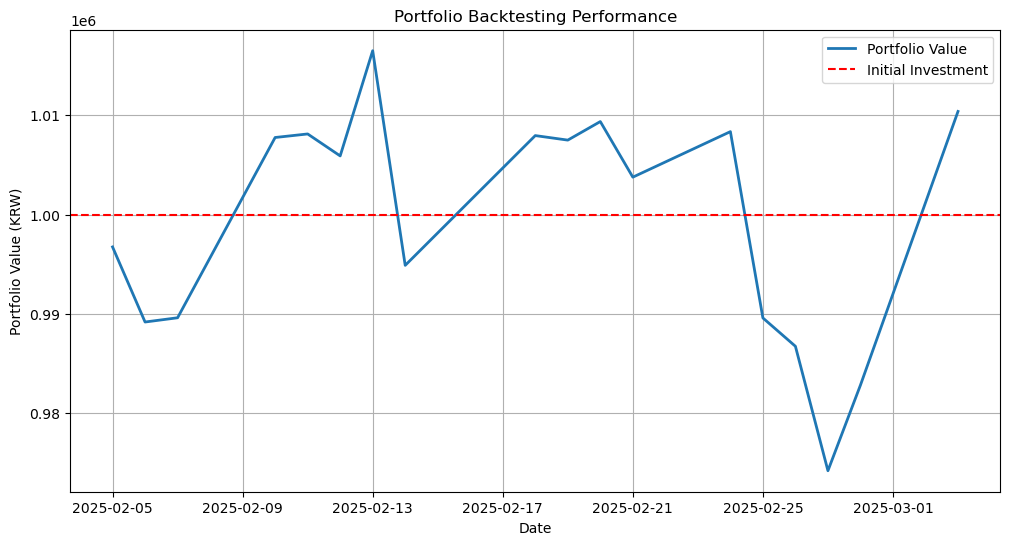

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Fetch asset data and convert to KRW
def get_asset_data(start_date, end_date):
    tickers = ['GLDM', 'WM', 'QQQM', 'BTC-KRW', 'KRW=X']
    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)['Close']

    combined_data = pd.DataFrame({
        'BTC_KRW': data['BTC-KRW'],
        'GLDM_KRW': data['GLDM'] * data['KRW=X'],
        'WM_KRW': data['WM'] * data['KRW=X'],
        'QQQM_KRW': data['QQQM'] * data['KRW=X']
    }).dropna()

    return combined_data

# Weighting functions
def uniform_weighting(log_returns):
    return np.ones(len(log_returns)) / len(log_returns)

def logarithm_weighting(log_returns):
    num_days = len(log_returns)
    log_weights = np.log(np.arange(1, num_days + 1) + 1)
    return log_weights / log_weights.sum()

def linear_weighting(log_returns):
    num_days = len(log_returns)
    linear_weights = np.linspace(0.1, 1, num_days)
    return linear_weights / linear_weights.sum()

# Compute downside volatility & covariance matrix
def downside_cov_matrix(log_returns, risk_free_rate=0.025):
    downside_returns = log_returns.copy()
    downside_returns[downside_returns > risk_free_rate / 252] = 0  

    downside_volatility = np.sqrt((downside_returns ** 2).mean(axis=0) * 252)
    downside_cov = downside_returns.cov() * 252  

    return downside_volatility, downside_cov

# Compute expected returns & downside volatility
def calculate_weighted_returns_volatility(log_returns, weighting_function):
    if weighting_function == uniform_weighting:
        weights = uniform_weighting(log_returns)
    elif weighting_function == logarithm_weighting:
        weights = logarithm_weighting(log_returns)
    elif weighting_function == linear_weighting:
        weights = linear_weighting(log_returns)
    else:
        raise ValueError("Invalid weighting function")

    weighted_mean_returns = (log_returns * weights.reshape(-1, 1)).sum(axis=0) * 252
    downside_volatility, downside_cov = downside_cov_matrix(log_returns)

    def portfolio_downside_volatility(weights):
        return np.sqrt(np.dot(weights.T, np.dot(downside_cov, weights)))

    return weighted_mean_returns, portfolio_downside_volatility

# Sortino ratio optimization
def max_sortino(log_returns, weighting_function, risk_free_rate=0.025):
    mean_returns, portfolio_downside_volatility = calculate_weighted_returns_volatility(log_returns, weighting_function)

    def neg_sortino_ratio(weights):
        return -np.dot(weights, mean_returns) / portfolio_downside_volatility(weights)

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(mean_returns)))
    initial_weights = np.ones(len(mean_returns)) / len(mean_returns)

    result = minimize(neg_sortino_ratio, initial_weights, method='SLSQP',
                      bounds=bounds, constraints=constraints,
                      options={'maxiter': 1000, 'ftol': 1e-9})

    return result.x / np.sum(result.x) if result.success else initial_weights

# Portfolio backtesting
def backtest_portfolio(weights, log_returns, risk_free_rate=0.025, initial_investment=1000000):
    portfolio_daily_returns = log_returns.dot(weights)

    cumulative_returns = (1 + portfolio_daily_returns).cumprod() * initial_investment

    annualized_return = portfolio_daily_returns.mean() * 252
    annualized_volatility = portfolio_daily_returns.std() * np.sqrt(252)

    downside_returns = portfolio_daily_returns[portfolio_daily_returns < risk_free_rate / 252]
    downside_deviation = np.sqrt(np.mean(downside_returns ** 2)) * np.sqrt(252) if len(downside_returns) > 0 else 1e-6
    sortino_ratio = annualized_return / downside_deviation

    print("\nPortfolio Backtesting Results")
    print(f"Final Portfolio Value: {cumulative_returns.iloc[-1]:,.0f} KRW")
    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Annualized Volatility: {annualized_volatility:.2%}")
    print(f"Sortino Ratio: {sortino_ratio:.2f}")

    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns, label="Portfolio Value", linewidth=2)
    plt.axhline(y=initial_investment, color='r', linestyle='--', label="Initial Investment")
    plt.title("Portfolio Backtesting Performance")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value (KRW)")
    plt.legend()
    plt.grid()
    plt.show()

# Calculate number of shares to buy
def calculate_shares_to_buy(weights, current_prices, total_capital, assets):
    capital_allocated = weights * total_capital  
    shares_to_buy = {}

    for i, asset in enumerate(assets):
        if asset == "BTC_KRW":
            shares_to_buy[asset] = f"{capital_allocated[i]:,.0f} KRW"
        else:
            shares_to_buy[asset] = f"{int(np.floor(capital_allocated[i] / current_prices[i]))} shares"

    return shares_to_buy

# Main execution
def main():
    training_start_date, training_end_date = '2024-03-04', '2025-03-04'
    backtest_start_date, backtest_end_date = '2025-02-04', '2025-03-04'

    training_data = get_asset_data(training_start_date, training_end_date)
    log_returns_train = np.log(training_data / training_data.shift(1)).dropna()

    risky_assets = ['GLDM_KRW', 'QQQM_KRW', 'WM_KRW', 'BTC_KRW']
    risky_returns_train = log_returns_train[risky_assets]

    weighting_function = logarithm_weighting  

    optimal_weights_sortino = max_sortino(risky_returns_train, weighting_function)

    print("\n=== Optimized Portfolio Weights ===")
    for asset, weight in zip(risky_assets, optimal_weights_sortino):
        print(f"{asset}: {weight:.2%}")

    latest_prices = training_data.iloc[-1][risky_assets]  

    total_capital = 9600000.0  

    shares_to_buy = calculate_shares_to_buy(optimal_weights_sortino, latest_prices.values, total_capital, risky_assets)

    print("\n=== Recommended Orders ===")
    for asset, value in shares_to_buy.items():
        print(f"{asset}: {value}")

    backtest_data = get_asset_data(backtest_start_date, backtest_end_date)
    log_returns_backtest = np.log(backtest_data / backtest_data.shift(1)).dropna()
    risky_returns_backtest = log_returns_backtest[risky_assets]

    backtest_portfolio(optimal_weights_sortino, risky_returns_backtest)

if __name__ == "__main__":
    main()
